In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt

# Exercises

The end result of this exercise should be a Jupyter notebook named model.

Using saas.csv or log data from API usage

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.
2. Forecast, plot and evaluate using each at least 4 of the methods we discussed:
* Last Observed Value
* Simple Average
* Moving Average
* Holt's Linear Trend
* Holt's Seasonal Trend
* Based on previous year/month/etc., this is up to you.


In [4]:
df = pd.read_csv('saas.csv')

In [7]:
df.columns = df.columns.str.lower()

In [14]:
df = df.rename(columns = {'month_invoiced' : 'month'})

In [15]:
df.head()

,month,customer_id,invoice_id,subscription_type,amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [23]:
df.tail()

,customer_id,invoice_id,subscription_type,amount
month,,,,
2017-12-31,1029395,5790453,0.0,0.0
2017-12-31,1029396,5790454,0.0,0.0
2017-12-31,1029397,5790455,3.0,15.0
2017-12-31,1029398,5790456,0.0,0.0
2017-12-31,1029399,5790457,0.0,0.0


In [17]:
df.subscription_type.value_counts()

0.0    496410
1.0    178212
2.0     70706
3.0     26474
4.0     18656
Name: subscription_type, dtype: int64

In [18]:
df.month = df.month.astype('datetime64')
df = df.set_index('month')
df = df.sort_index()

In [19]:
df.head()

,customer_id,invoice_id,subscription_type,amount
month,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   customer_id        790458 non-null  int64  
 1   invoice_id         790458 non-null  int64  
 2   subscription_type  790458 non-null  float64
 3   amount             790458 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 30.2 MB


In [22]:
df.amount.value_counts()

0.0     496410
5.0     178212
10.0     70706
15.0     26474
20.0     18656
Name: amount, dtype: int64

In [30]:
df.describe()

,customer_id,invoice_id,subscription_type,amount
count,7.904580e+05,7.904580e+05,790458.000000,790458.000000
mean,1.012913e+06,5.395228e+06,0.599235,2.996174
std,7.591992e+03,2.281857e+05,0.950380,4.751901
min,1.000000e+06,5.000000e+06,0.000000,0.000000
25%,1.006405e+06,5.197614e+06,0.000000,0.000000
50%,1.012797e+06,5.395228e+06,0.000000,0.000000
75%,1.019154e+06,5.592843e+06,1.000000,5.000000
max,1.029399e+06,5.790457e+06,4.000000,20.000000


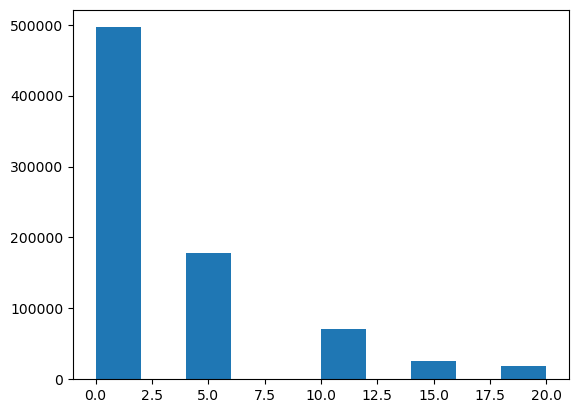

In [32]:
plt.hist(df.amount)
plt.show()

In [24]:
df.loc['2014'].shape

(227542, 4)

In [25]:
df.loc['2015'].shape

(204352, 4)

In [26]:
df.loc['2016'].shape

(186275, 4)

In [27]:
df.loc['2017'].shape

(172289, 4)

In [78]:
df_resampled = pd.DataFrame(df.resample('M')['amount'].sum())

In [79]:
df_resampled.head()

,amount
month,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [80]:
# splitting into train/test per instructions
train = df_resampled.loc[:'2016']
test = df_resampled.loc['2017':]

In [81]:
print (f'train shape: {train.shape}')
print (f'test shape: {test.shape}')

train shape: (36, 1)
test shape: (12, 1)


In [82]:
train.head()

,amount
month,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


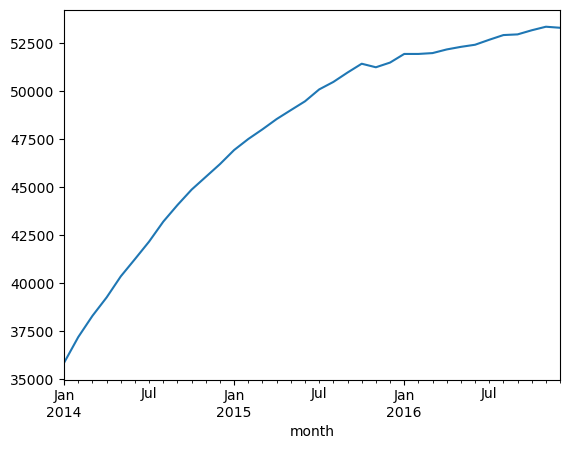

In [83]:
train.amount.plot()
plt.show()

In [84]:
train.loc['2014-01'].amount.sum()

35850.0

In [85]:
train.loc['2016-01'].amount.sum()

51955.0

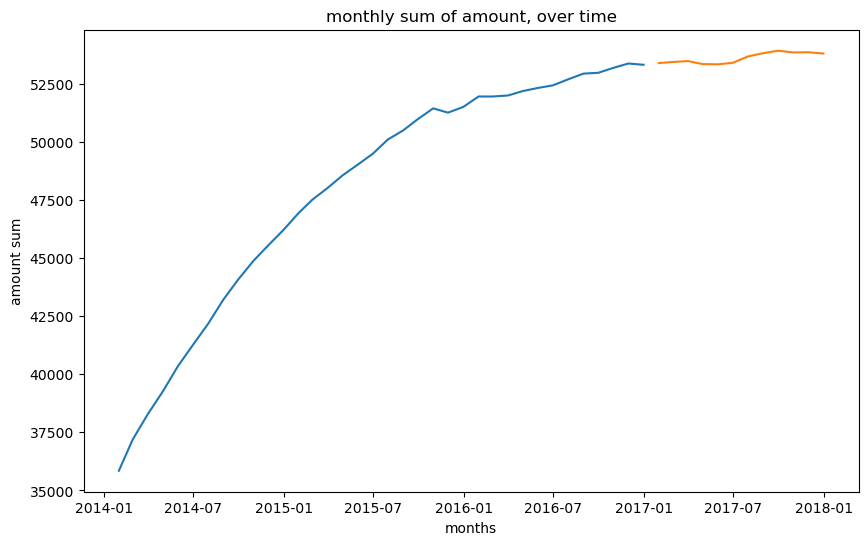

In [86]:
plt.figure(figsize=(10,6))
plt.plot(train.amount)
plt.plot(test.amount)
plt.title('monthly sum of amount, over time')
plt.xlabel('months')
plt.ylabel('amount sum')
plt.show()

## very quick exploration -- review
- no season trends I see so far
- so predicting the last thing is going to be pretty good

In [59]:
# evaluation function to compute rmse
# calculate an error metric on the validation's target versus predictions
def evaluate(validate, yhat_df, target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(
        sqrt(
            mean_squared_error(
            validate[target_var],
            yhat_df[target_var])
        ), 0)
    return rmse

In [60]:
# plot and evaluate 
def plot_and_eval(train, validate, yhat_df, target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var], linewidth=1)
    plt.title(target_var)
    rmse = evaluate(validate, yhat_df, target_var)
    print(target_var, f'-- rmse: {round(rmse,2)}')
    plt.show()

In [61]:
# function to store rmse for comparison purposes
def append_eval_df(eval_df, model_type, validate, yhat_df, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(validate, yhat_df, target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    return pd.concat([eval_df, pd.DataFrame(d)])

## Forecast
* Baseline Models
    * Last Observed Value
    * Simple Average
    * Moving Average
* Non-Baseline Models
    * Previous Cycle
    * Holt's Linear Trend
    * Holt's Seasonal Trend

In [64]:
# Create the empty evaluate dataframe for holding model metrics
# target_var is less important since I'm only predicting on amount
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


### Last Observed Value

In [87]:
# predict on the last monthly sum of amount
train.amount[-5:]

month
2016-08-31    52940.0
2016-09-30    52975.0
2016-10-31    53190.0
2016-11-30    53375.0
2016-12-31    53320.0
Freq: M, Name: amount, dtype: float64

In [88]:
# take the last month's amount sum from train and assign it to variable last_month_sum
last_month_sum = train.amount[-1]

# make a yhat_df prediction dataframe
yhat_df = pd.DataFrame( {'amount': last_month_sum}, index = test.index )

In [89]:
yhat_df.head()

,amount
month,
2017-01-31,53320.0
2017-02-28,53320.0
2017-03-31,53320.0
2017-04-30,53320.0
2017-05-31,53320.0


amount -- rmse: 366.0


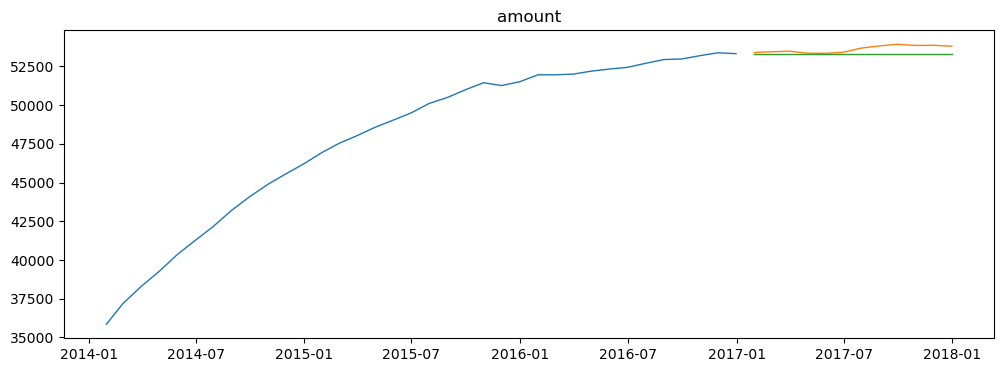

In [90]:
plot_and_eval(train, test, yhat_df, 'amount')

In [91]:
eval_df = append_eval_df(eval_df, 'last_observed_value', test, yhat_df, 'amount')
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,366.0


### Simple Average

In [94]:
# compute average monthly amount
avg_amount = round(train.amount.mean(), 2)

# make new yhat_df with this prediction

yhat_df = pd.DataFrame ( {'amount': avg_amount}, index=test.index )
yhat_df.head(2)

,amount
month,
2017-01-31,47916.67
2017-02-28,47916.67


amount -- rmse: 5700.0


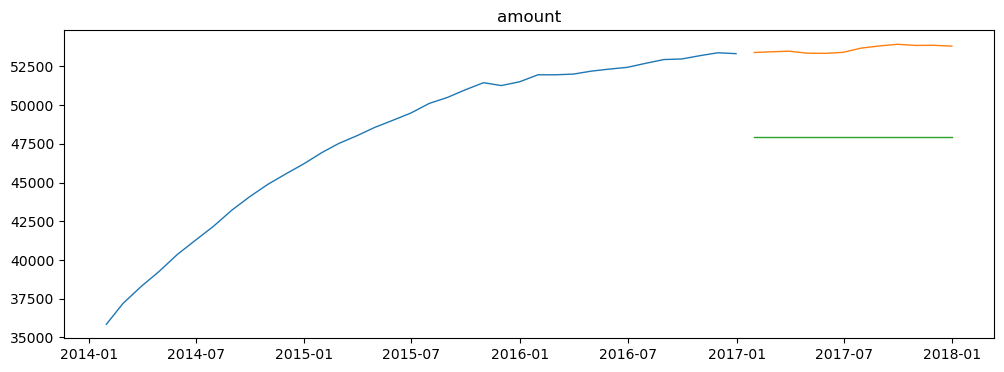

In [95]:
plot_and_eval(train, test, yhat_df, 'amount')

In [96]:
eval_df = append_eval_df(eval_df, 'simple_average', test, yhat_df, 'amount')
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,366.0
0,simple_average,amount,5700.0


In [100]:
# can reset index later if required
# eval_df.reset_index(drop=True)

### Moving Average
- Let's do 2,3,6,12 month rolling averages

In [101]:
periods = [2,3,6,12]

for p in periods:
    # set new rolling amount
    rolling_amount = round(train.amount.rolling(p).mean()[-1], 2)
    # make new prediction dataframe with rolling_amount
    yhat_df = pd.DataFrame( {'amount' : rolling_amount}, index=test.index )
    # make a new string to use in appending in eval_df
    model_type = str(p) + '_month_moving_avg'
    # update eval_df
    eval_df = append_eval_df(eval_df, model_type, test, yhat_df, 'amount')

eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,366.0
0,simple_average,amount,5700.0
0,2_month_moving_avg,amount,344.0
0,3_month_moving_avg,amount,386.0
0,6_month_moving_avg,amount,574.0
0,12_month_moving_avg,amount,1024.0


amount -- rmse: 344.0


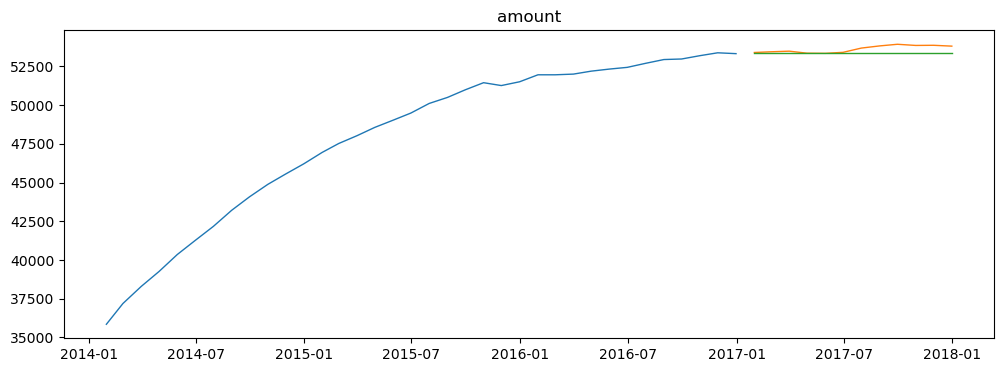

In [103]:
### So far, 2_month_moving_average is the best
# plot it for fun

two_mo_roll_avg = round (train.amount.rolling(2).mean()[-1], 2)

yhat_df = pd.DataFrame( {'amount' : two_mo_roll_avg}, index=test.index )

plot_and_eval(train, test, yhat_df, 'amount')


## Non-Baseline Models
### Holt-Winters  Linear

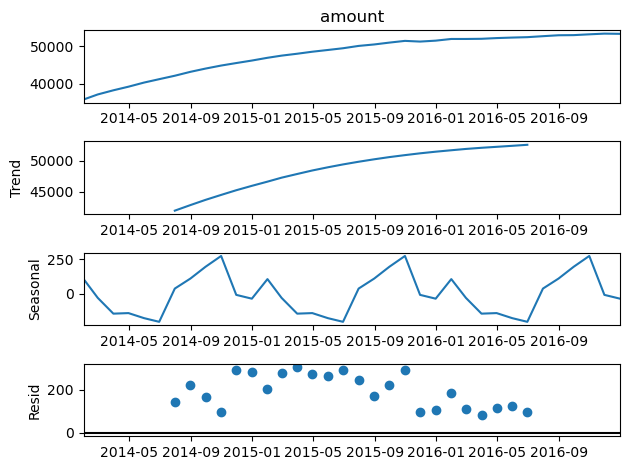

In [105]:
sm.tsa.seasonal_decompose(train.amount).plot()
plt.show()

In [106]:
## Weird that this shows seasonality.  I guess a little tiny bit... maybe.

### Make/Fit/Use the thing
* some hyper parameters to worry about
    * First when we make the thing by calling Holt
    * exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)
    * damped = True/False
        * with Holt, forecasts tend to increase or decrease indefinitely into the future. To avoid absurd long term predictions, use the Damped method (True) which sets a damping parameter between 0< ϕ <1.

* Second when we fit the thing:
    * smoothing_level = between 0 and 1
        * Closer to 0, the level doesn't change with each new observation
        * Closer to 1, the level reacts strongly with each new observation
    * smoothing_slope = between 0 and 1
        * Closer to 0, trend is not changing over time
        * Closer to 1, trend is changing significantly over time
    * optimized 
        * use the auto-optimization that allow statsmodels to automatically find an optimized value for us.
        * I think this is the way to go

In [108]:
model = Holt(train.amount, exponential=False, damped=True)
model = model.fit(optimized=True)

yhat_df.amount = round (model.predict (start=test.index[0], end=test.index[-1]), 2)
yhat_df.head()

,amount
month,
2017-01-31,53519.52
2017-02-28,53641.20
2017-03-31,53761.74
2017-04-30,53881.17
2017-05-31,53999.48


amount -- rmse: 607.0


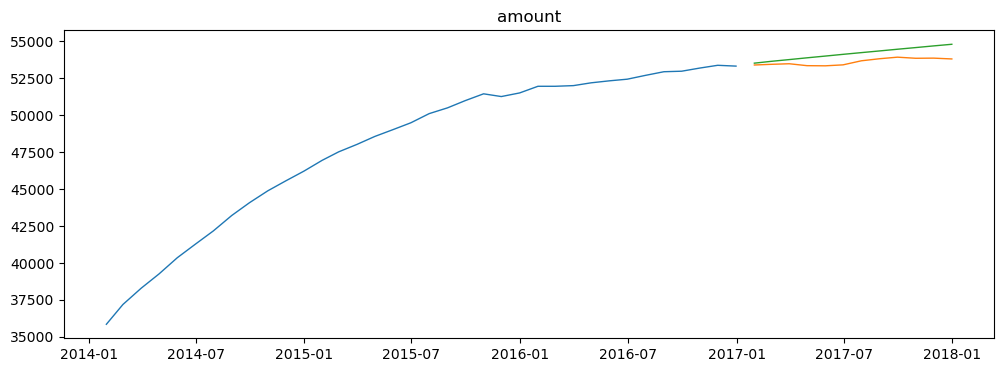

In [109]:
plot_and_eval(train, test, yhat_df, 'amount')

In [110]:
eval_df = append_eval_df(eval_df, 'holt-linear', test, yhat_df, 'amount')
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,366.0
0,simple_average,amount,5700.0
0,2_month_moving_avg,amount,344.0
0,3_month_moving_avg,amount,386.0
0,6_month_moving_avg,amount,574.0
0,12_month_moving_avg,amount,1024.0
0,holt-linear,amount,607.0


## Holt's Seasonal Trend

* Make the thing: ExponentialSmoothing()
* Fit the thing
* Use the thing with .forecast()

* Hyperparamaters:

    * seasonal_periods: The number of periods representing one cycle of seasonality. This is why performing a decomposition plot can be valuable, as this number needs to be entered manually.
    * trend: Whether the overall trend is additive (trend='add') or multiplicative (trend='mul')
    * seasonal: Whether the seasonality is additive (seasonal='add') or multiplicative (seasonal='mul')
    * damped: If we want the trend to reduce over the length of the forecast to avoid absurd long term predictions, we can set damped=True

Given our smaller dataset, rather than choosing any one combination of hyperparameters, we can create multiple models to test different combinations:

In [111]:
# we'll set seasonal_periods to 12 (based on the seasonal decomposition plot)
# set trend to 'add'
# can try seasonal both 'add' and 'mul'
# damped both True and False

In [112]:
import itertools

In [113]:
combos = list(itertools.product(['add', 'mul'], [True, False]))
combos

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [ ]:
### Start back up here. Almost done.

In [ ]:
holt_seasonal_ts = {}
for i, combo in enumerate(combos):
    holt_seasonal_ts['hst_fit_' + str(i) = ExponentialSmoothing(
                                            seasonal_periods=12,
        